# HOMEWORK 13

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [139]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras import Model

from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

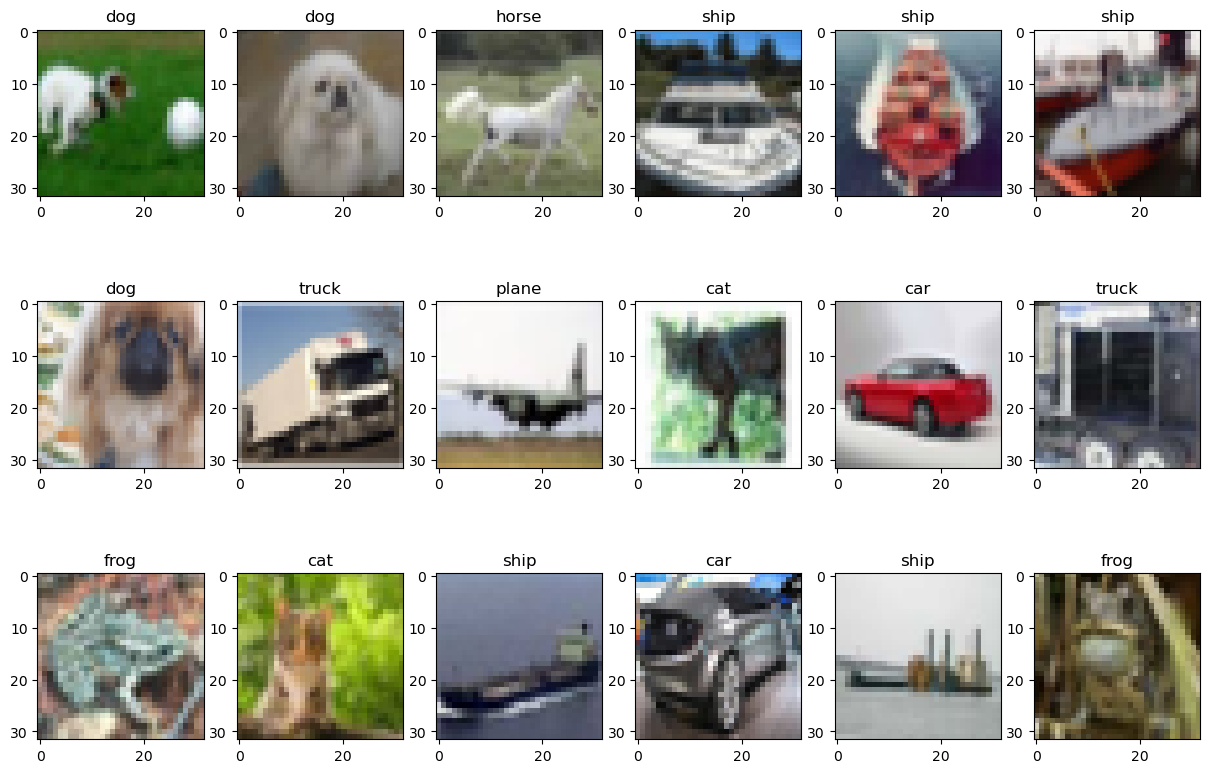

In [125]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer',
           5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):
    plt.subplot(3, 6, ii + 1)
    # Pick a random sample
    idx = np.random.randint(0, len(x_train))
    # Show the image and the label
    plt.imshow(x_train[idx])
    plt.title(classes[int(y_train[idx][0])])


Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

(Text(0.5, 0, 'Class'), Text(0, 0.5, 'Number of images'))

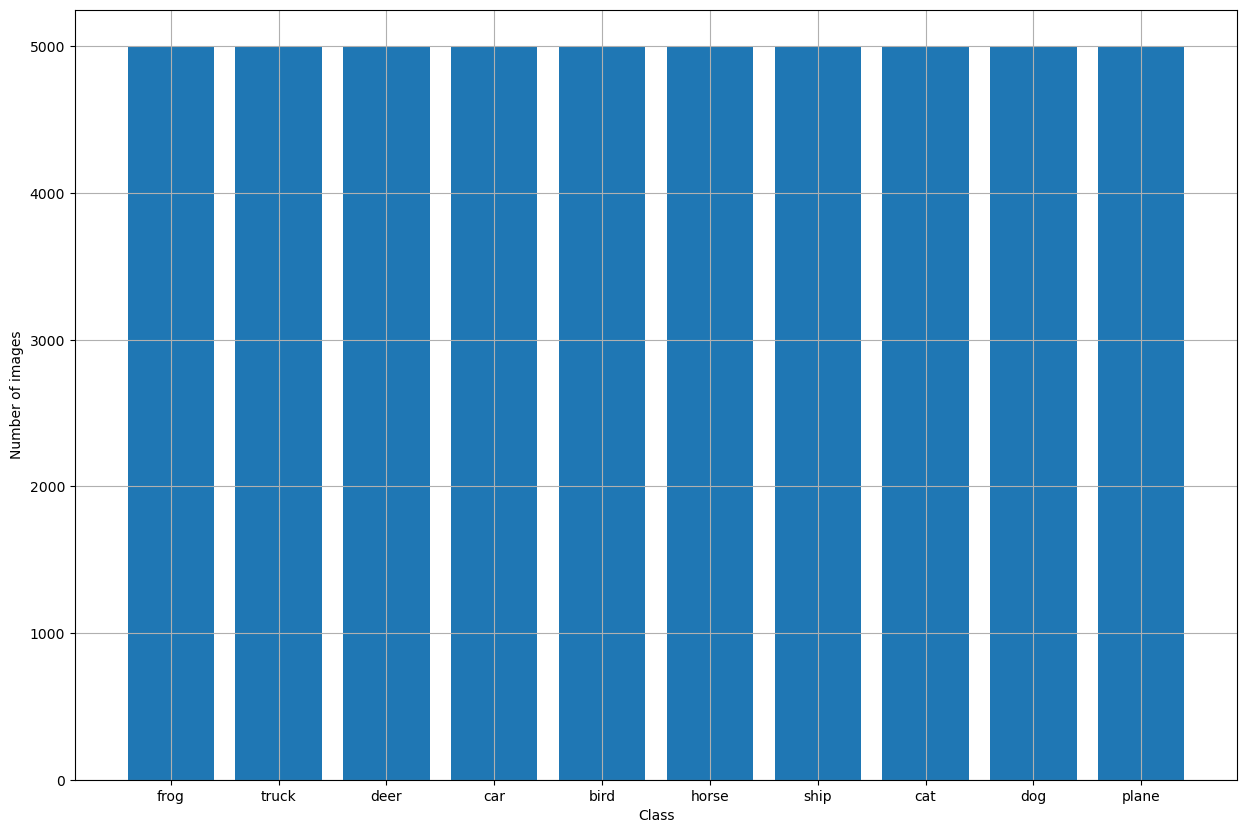

In [126]:
from collections import Counter

hist = Counter(y_train.flatten())

plt.bar([classes[k] for k in hist.keys()], hist.values()), plt.grid(True)
plt.xlabel('Class'), plt.ylabel('Number of images')


### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [127]:
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

y_train_vec = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_vec = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)


Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [146]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)

net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)

net = Conv2D(64, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)

net = Flatten()(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,154 (102.16 KB)

 Trainable params: 26,154 (102.16 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training

Compile the model and train it.

In [147]:
epochs = 25
batch_size = 128

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train_norm, y_train_vec, batch_size=batch_size, epochs=epochs, validation_split=0.1)
print('Elapsed time', time() - start)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2719 - loss: 1.9902 - val_accuracy: 0.4252 - val_loss: 1.6249
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4605 - loss: 1.5023 - val_accuracy: 0.4774 - val_loss: 1.4566
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5063 - loss: 1.3808 - val_accuracy: 0.4954 - val_loss: 1.4394
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5359 - loss: 1.3114 - val_accuracy: 0.5342 - val_loss: 1.3261
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5590 - loss: 1.2476 - val_accuracy: 0.5694 - val_loss: 1.2321
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5798 - loss: 1.1933 - val_accuracy: 0.5890 - val_loss: 1.1679
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5982 - loss: 1.1445 - val_accuracy: 0.6042 - val_loss: 1.1368
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6157 - loss: 1.1028 - val_accu

Train Acc      0.7345777750015259
Validation Acc 0.6801999807357788


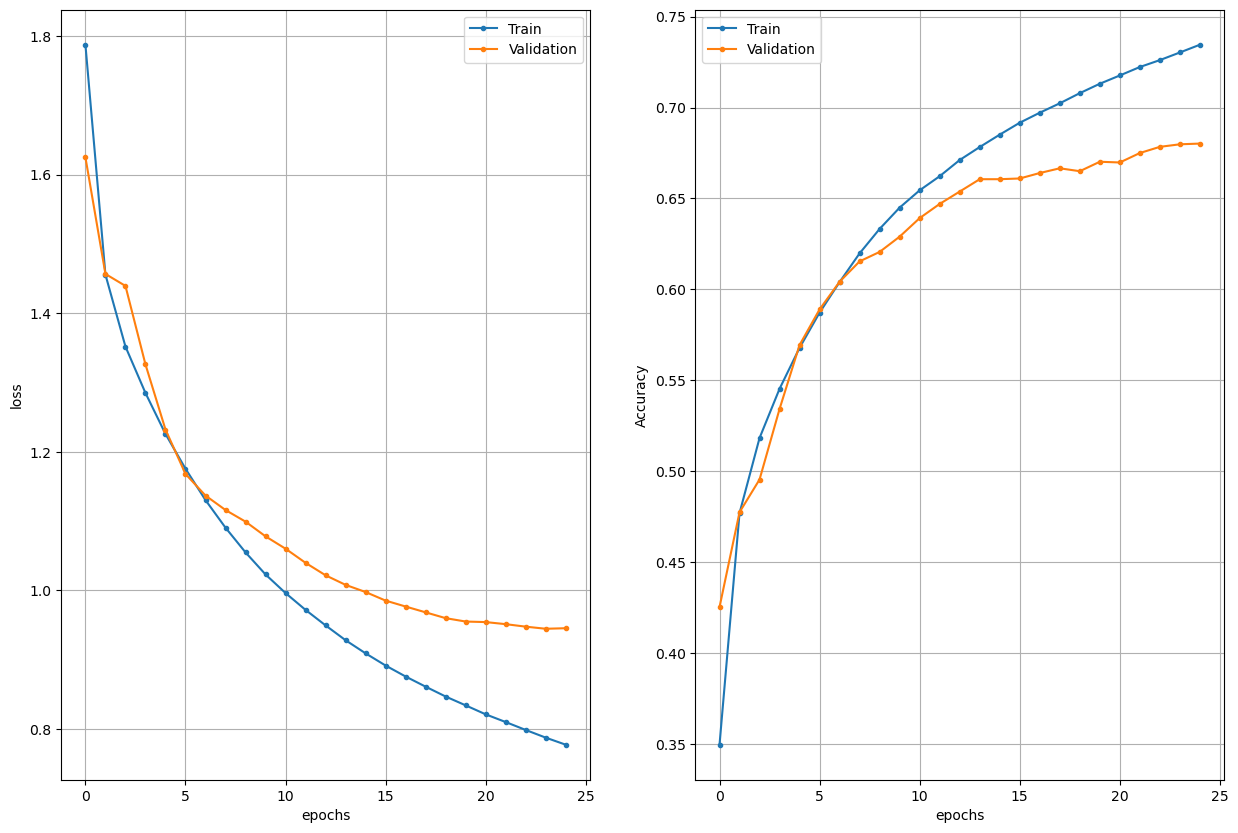

In [148]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [149]:
y_true = np.argmax(y_test_norm, axis=1)
y_pred = model.predict(x_test_norm)
y_pred = np.argmax(y_pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [151]:
# Compute and print the accuracy for each class
# for class_id, class_name in classes.items():

for class_id, class_name in classes.items():
    mask = y_true == class_id

    tp = np.sum(y_pred[mask] == class_id)
    total = np.sum(mask)

    acc = tp/total
    print(class_name, acc)

plane 0.715
car 0.831
bird 0.512
cat 0.372
deer 0.703
dog 0.633
frog 0.737
horse 0.7
ship 0.75
truck 0.781


In [152]:
# Print the overall stats
ev = model.evaluate(x_test_norm, y_test_norm)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6844 - loss: 0.9470
Test loss   0.9671629071235657
Test metric 0.6733999848365784


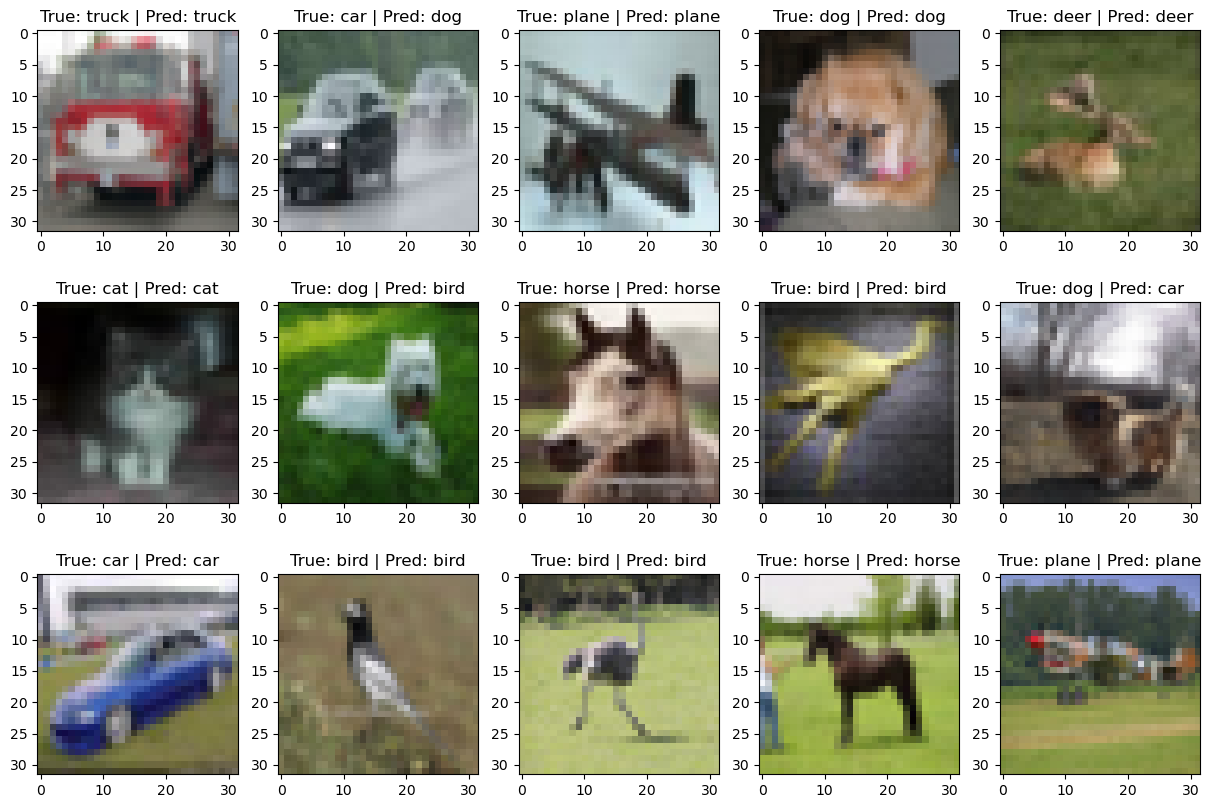

In [153]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, len(x_test))
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions
* What is the overall accuracy of the classifier? Quite poor. Test loss is super high. Test loss   0.9933018684387207 Test metric 0.6581000089645386
* What modifications would you do in order to improve the classification accuracy? Add layers. Ask internet/claude ai. Open alexnet article and read how it works

* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve? Added a layer. slightly improved
Test loss   0.9671629071235657
Test metric 0.6733999848365784.